In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import glob
import math

In [111]:
from PIL import Image
import os
path = '97028583.bmp'

bmp = Image.open(path)
bmp.save(os.path.splitext(path)[0]+'.jpg')

In [5]:
def read_img(path):
    original_img = cv2.imread(path)
    return original_img

In [6]:
########## Making mask for removing background #############

def make_mask(original_img):

    ## change to lab for making mask

    img_mask = original_img.copy()

    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_RGB2BGR)
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2Lab)
    
    ## blur _02 
    # kernel_size = odds / value = img.mean()


    blur_k = int((img_mask.mean()*0.5)//2)*2+1
    img_mask = cv2.medianBlur(img_mask, blur_k)
    
    ## change to Grayscale for threshold

    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_Lab2BGR)
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)

    ## binary / value = img.mean()

    if img_mask.mean() > 100 : 
      th = img_mask.mean()*0.94
    else : 
      th = img_mask.mean()

    ret, img_mask = cv2.threshold(img_mask, th, 255, cv2.THRESH_BINARY)

    ## mask based Max value of contours

    contours, hierarchy = cv2.findContours(img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img_mask.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)
    
    ## Applying for dilation

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (8,8))
    mask = cv2.dilate(mask,k)
    return mask

In [74]:
######## background cut based mask ##########

def cut_mask(original_img, mask):

    ## copying
    img_for_cut = original_img.copy()

    ## H/W
    height, width = img_for_cut.shape[:2]

    ## mask
    mask_list = mask.tolist()
    
    for y in range(int(height*0.05),height):
        if max(mask[y,int(width*0.3):int(width*0.7)]) < 0:
            start_y = y-int(height*0.05)
            break
            
    for x in range(int(width*0.05),width):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            start_x = x-int(width*0.05)
            break
            
    for x in range(int(width*0.95),-1,-1):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            end_x = x+int(width*0.05)
            break
            
    cut_index = 0
    if mask_list[height-1][-1] == 255 or mask_list[height-1][0] == 255:
        for n in reversed(range(height)):
            if mask_list[n][0] == 0 or mask_list[n][-1] == 0:
                cut_index = n
                break
                
    if cut_index == 0:
        cut_index = height

    ## converting color
    img_for_cut = cv2.cvtColor(img_for_cut, cv2.COLOR_BGR2GRAY) 

    img_for_cut = img_for_cut[start_y:(cut_index-1),start_x:end_x]
    mask = mask[start_y:(cut_index-1),start_x:end_x]

    ## remove background
    masked = cv2.bitwise_and(img_for_cut, mask)

    return masked

In [116]:
def rotate_for_carpal(img):
    a = img.copy()
    img = cv2.cvtColor(a, cv2.COLOR_GRAY2BGR)
    ###아래 테두리가 흰색 또는 검은색인 경우를 고려해서 아래부분 자르기
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    th_l = th.tolist()

    cut_index = 0
    # 맨 밑 처음이나 끝에 흰색이 나오면 검은색이 나오는 부분까지 자르기
    if th_l[len(th_l) - 1][-1] == 255 or th_l[len(th_l) - 1][0] == 255:
        for i in reversed(range(len(th_l))):
            if th_l[i][0] == 0 and th_l[i][-1] == 0:
                cut_index = i
                break

    # 맨 밑 처음이 검정색이면 흰색이 나오는 부분까지 자르기
    if th_l[len(th_l) - 1][0] == 0 or th_l[len(th_l) - 1][-1] == 0:
        for i in reversed(range(len(th_l))):
            if th_l[i].count(255) > 0:
                cut_index = i
                break

    if cut_index == 0:
        cut_index = len(th_l)

    img = img[:(cut_index - 1)]

    ###회전하기
    h, w = img.shape[:2]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    th_l = th.tolist()

    # 밑에서부터 처음으로 검은 색이 나오는 부분이 lower
    for i in reversed(range(len(th_l))):
        if th_l[i][0] == 0:
            lower = i
            break

    # 만약 맨 밑이 lower면 이미지의 90퍼센트 부분을 lower로 정의
    if lower == h - 1:
        lower = int(len(th_l) * 0.9)

    # upper는 lower에서 5퍼센트만큼 올라간 부분
    slice5 = int(len(th) * 0.05)
    upper = lower - slice5

    # x, y좌표들은 이미지의 85퍼센트(upper)와 90퍼센트(lower) 부분의 손목 가운데 지점들
    x, y = [], []
    for i in range(slice5):
        cnt = th_l[i + upper].count(255)
        index = th_l[i + upper].index(255)
        x.append([i + upper])
        y.append([int((index * 2 + cnt - 1) / 2)])

    # x,y좌표로 단순선형회귀 그리기
    model = LinearRegression()
    model.fit(X=x, y=y)

    # 회전
    angle = math.atan2(h - 0, int(model.predict([[h]])) - int(model.predict([[0]]))) * 180 / math.pi
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle - 90, 1)
    rotate = cv2.warpAffine(img, M, (w, h))

    # 회전한 부분을 자르기
    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            start_x = i
            break

    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            end_x = i

    s_point = h - int((int(model.predict([[h]]) - start_x)) * math.tan(math.pi * ((90 - angle) / 180)))
    e_point = h - int((end_x - int(model.predict([[h]]))) * math.tan(math.pi * ((angle - 90) / 180)))
    point = min(s_point, e_point)
    img = rotate[:point]

    return img

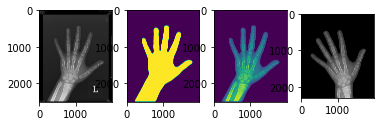

In [118]:
path = '97028583.bmp'
a = read_img(path)
mask = make_mask(a)
masked = cut_mask(a,mask)
final = rotate_for_carpal(masked)

plt.subplot(141)
plt.imshow(a)
plt.subplot(142)
plt.imshow(mask)
plt.subplot(143)
plt.imshow(masked)
plt.subplot(144)
plt.imshow(final)